# Preprocessing an audio dataset
Preprocessing audio datasets most of the time will involve the following steps:

- Resampling the audio data
- Filtering the dataset
- Converting audio data to model’s expected input


## Resampling the audio data
If there's a discrepancy between the sampling rates, you can resample the audio to the model's expected sampling rate.

In [ ]:
%pip install "datasets[audio]" gradio transformers

In [ ]:
from datasets import load_dataset, Audio
import librosa

minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")

In [ ]:
minds = minds.cast_column("audio", Audio(sampling_rate=16_000))
minds

## Filtering the dataset

In [ ]:
MAX_DURATION_IN_SECONDS = 20.0


def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

In [ ]:
# use librosa to get example's duration from the audio file
new_column = [librosa.get_duration(path=x) for x in minds["path"]]
minds = minds.add_column("duration", new_column)

# use 🤗 Datasets' `filter` method to apply the filtering function
minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])

# remove the temporary helper column
minds = minds.remove_columns(["duration"])
minds

In [ ]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], padding=True
    )
    return features

In [ ]:
minds = minds.map(prepare_dataset)
minds

### There are two Operations that Whispers feature extractor performs on the audio data

One can see that the feature extractor for openai whispers pads and or truncates the audio to a fixed length. Specifically, it pads the audio to 30 seconds and truncates it to 30 seconds. Since all elements in the batch are padded/truncated to a maximum length in the input space, there is no need for an attention mask.



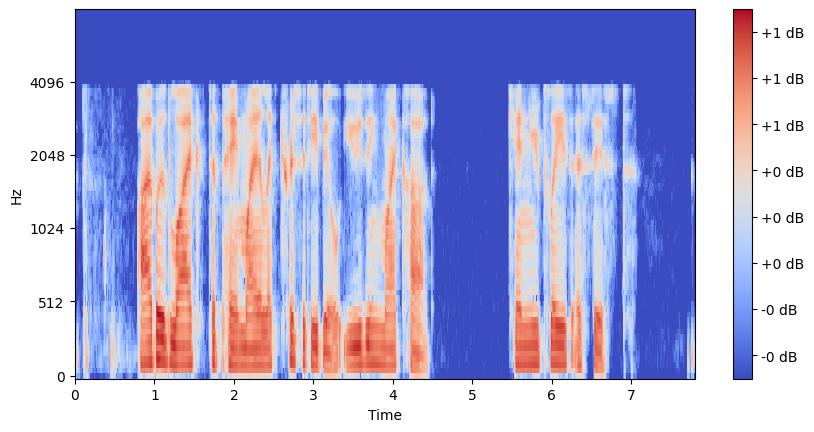

In [64]:
import numpy as np
import matplotlib.pyplot as plt

example = minds[0]
input_features = example["input_features"]

plt.figure().set_figwidth(10)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar(format="%+2.0f dB")

In [ ]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("openai/whisper-small")

In [63]:
output_array = processor(
    example["audio"]["array"],
    sampling_rate=feature_extractor.sampling_rate,
)
print("feature_extractor.sampling_rate:", feature_extractor.sampling_rate)
print("Output features shape:", output_array.input_features.shape)
print("Output size:", output_array.input_features.size)
print("Output features type:", type(output_array.input_features))
output_array

feature_extractor.sampling_rate: 16000
Output features shape: (1, 80, 3000)
Output size: 240000
Output features type: <class 'numpy.ndarray'>


{'input_features': array([[[-0.6273271 , -0.43024588,  0.01525426, ..., -0.6273271 ,
         -0.6273271 , -0.6273271 ],
        [-0.6273271 , -0.37326014,  0.26793718, ..., -0.6273271 ,
         -0.6273271 , -0.6273271 ],
        [-0.6273271 , -0.33587098,  0.42833835, ..., -0.6273271 ,
         -0.6273271 , -0.6273271 ],
        ...,
        [-0.6273271 , -0.6273271 , -0.6273271 , ..., -0.6273271 ,
         -0.6273271 , -0.6273271 ],
        [-0.6273271 , -0.6273271 , -0.6273271 , ..., -0.6273271 ,
         -0.6273271 , -0.6273271 ],
        [-0.6273271 , -0.6273271 , -0.6273271 , ..., -0.6273271 ,
         -0.6273271 , -0.6273271 ]]], shape=(1, 80, 3000), dtype=float32)}